# Modeling reproduction rate based on government measures in effect

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

# see all columns at once with scrolling
pd.set_option('display.max_columns', None, 'display.max_rows', 100)

## Data
Create a table with

| Country | Date      | IndoorOver100 | MassGatherAll | StayHomeOrderPartial | ... | reproduction_rate |
|---------|-----------|---------------|---------------|----------------------|-----|-------------------|
| Austria | 3-10-2020 | 1             | 0             | 0                    |     | 1.5               |
| UK      | 1-2-2020  | 0             | 0             | 1                    |     | 0.8               |
| UK      | 2-4-2020  | 1             | 1             | 1                    |     | 0.2               |

In [12]:
TAU_RANGE = 31
owid = pd.read_csv('./data/1_owid/owid-covid-data.csv')
eu_response = pd.read_csv('./data/2_ecdc/country_response_measures.csv')

# df is the final dataset to use
df = owid.loc[:,["location","date","reproduction_rate",'population',
       'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
       'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'hospital_beds_per_thousand','life_expectancy', 'human_development_index']]

# reproduction_i is the reproduction rate after i days.
for i in range(1,TAU_RANGE):
    df['reproduction_'+str(i)] = df.groupby('location')['reproduction_rate'].shift(-i)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58154 entries, 0 to 58153
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   location                    58154 non-null  object 
 1   date                        58154 non-null  object 
 2   reproduction_rate           44995 non-null  float64
 3   population                  57821 non-null  float64
 4   population_density          56597 non-null  float64
 5   median_age                  55335 non-null  float64
 6   aged_65_older               54691 non-null  float64
 7   aged_70_older               55021 non-null  float64
 8   gdp_per_capita              55351 non-null  float64
 9   extreme_poverty             37886 non-null  float64
 10  cardiovasc_death_rate       55931 non-null  float64
 11  diabetes_prevalence         56575 non-null  float64
 12  female_smokers              44174 non-null  float64
 13  male_smokers                435

In [13]:
# only keep rows in df that match to a country in eu_response
df = df[[x in eu_response["Country"].unique() for x in df["location"]]]

# initialize a column for each response type with all 0s
for response in eu_response["Response_measure"].unique():
    try:
        df.insert(len(df.columns), response, 0)
    except ValueError:  # ValueError thrown if df already has that column
        pass

# iterate through each government response and fill in 1s for between date_start and date_end for the correct country
for _, row in eu_response.iterrows():
    df.loc[(df["location"] == row["Country"])
        & (pd.to_datetime(df["date"]) >= pd.to_datetime(row["date_start"]))
        & (pd.to_datetime(df["date"]) < (pd.datetime(2030,1,1) if pd.isnull(pd.to_datetime(row["date_end"])) else pd.to_datetime(row["date_end"]))),    # force True if end_date == NaT
        row["Response_measure"]] = 1 # column to change

<ipython-input-13-a1b90a2cb6af>:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  & (pd.to_datetime(df["date"]) < (pd.datetime(2030,1,1) if pd.isnull(pd.to_datetime(row["date_end"])) else pd.to_datetime(row["date_end"]))),    # force True if end_date == NaT


## Linear Model
We perform OLS with each of the categories of responses as inputs (1 if active, 0 if not) to predict reproductive rate on that day (may have to shift reproductive rate by $\tau$ days)

The categories with largest negative coefficients are the most impactful (they reduce the reproductive rate the most)

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [15]:
df.info

<bound method DataFrame.info of              location        date  reproduction_rate  population  \
2824          Austria  2020-02-25                NaN   9006400.0   
2825          Austria  2020-02-26                NaN   9006400.0   
2826          Austria  2020-02-27                NaN   9006400.0   
2827          Austria  2020-02-28                NaN   9006400.0   
2828          Austria  2020-02-29                NaN   9006400.0   
...               ...         ...                ...         ...   
55012  United Kingdom  2020-12-31                NaN  67886004.0   
55013  United Kingdom  2021-01-01                NaN  67886004.0   
55014  United Kingdom  2021-01-02                NaN  67886004.0   
55015  United Kingdom  2021-01-03                NaN  67886004.0   
55016  United Kingdom  2021-01-04                NaN  67886004.0   

       population_density  median_age  aged_65_older  aged_70_older  \
2824              106.749        44.4         19.202         13.748   
2825     

In [16]:
# prepare data and divide train & test set
df = df.dropna()
train, test = train_test_split(df, test_size=0.1)

In [17]:
Xtrain = train[eu_response["Response_measure"].unique()]
Xtest = test[eu_response["Response_measure"].unique()]
train_score = []
test_score = []
for i in range(0,TAU_RANGE):    
    if i == 0:
        Ytrain = train["reproduction_rate"]
        Ytest = test["reproduction_rate"]
    else:
        Ytrain = train["reproduction_"+str(i)]
        Ytest = test["reproduction_"+str(i)]
    linear_regressor = LinearRegression()
    linear_regressor.fit(Xtrain, Ytrain)
    train_score = train_score + [linear_regressor.score(Xtrain,Ytrain)]
    test_score = test_score + [linear_regressor.score(Xtest,Ytest)]

<AxesSubplot:xlabel='tau'>

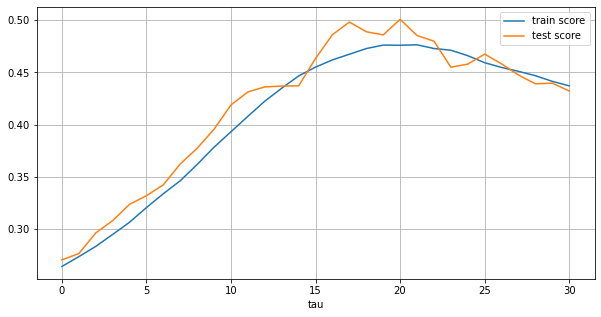

In [18]:
score_by_tau = pd.DataFrame({'tau':range(0,TAU_RANGE),'train score':train_score,'test score':test_score})
score_by_tau.set_index('tau').plot(figsize=(10,5), grid=True)

In [ ]:
train_score

In [ ]:
test_score

In [ ]:
coefficients = dict(zip(eu_response["Response_measure"].unique(), linear_regressor.coef_))
plt.figure(figsize=(6,12))
plt.barh(y = list(coefficients.keys()), width = coefficients.values())
plt.title("Coefficients $\\beta$ for each response_measure")